# Assignment 3: Sensitivity Analysis with Sobol Indices
#### Moritz Kick, Maximilian Nowak

In [24]:
# Import modules from source
import os, sys
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as lin

# from sinfo import sinfo
# sinfo()

## Implementation of Sobol indices

### 1. Implement the construction of Sobol matrices

In [25]:
from assignment3.sobol import create_sobol_matrices

pass

### 2. Implement the computation of Sobol total-effect indices

In [26]:
from assignment3.sobol import compute_total_indices

pass

### 3. Verify your implementation

In [27]:
from assignment2.lhs import latin_hypercube_uniform

# Generate Latin hypercube samples
n_samples = 1000
dim = 2

# Generate random samples
A, B = latin_hypercube_uniform(dim, n_samples), latin_hypercube_uniform(dim, n_samples)

# Get sobol matrix
A_b = create_sobol_matrices(A, B)

# Define test functions
f1 = lambda X: X[:, 0] + X[:, 1]
f2 = lambda X: X[:, 0] + 2*X[:, 1]**4
f3 = lambda X: X[:, 0] + 1/np.tan(np.pi * X[:, 1])
f = f2
f_A = f(A)
f_AB = np.array([f(X) for X in A_b])
r = compute_total_indices(f_A, f_AB)
print(r.shape)
print("%.6f %.6f" % (r[0], r[1]))

(2,)
0.215522 0.759715


## Application to the model

### 4. Construct sample matrices $A, B ∈ R^{N×n}$

In [28]:
from assignment2.lhs import latin_hypercube_uniform

# Construct parameter domain like in assignment 2
beta_range = [1, 3]  # average number of contacts per week
alpha_range = [7/14, 7/2]  # mean latency rate per week
gamma_range = [7/14, 7/7]  # mean recovery rate per week
i0_range = [500, 2500]  # initial number of infected individuals

param_domain = np.array([beta_range, alpha_range, gamma_range, i0_range])

# LHS sampling
dim = 4
n_samples = 1000
A = latin_hypercube_uniform(dim=dim, n_samples=n_samples, low=param_domain[:, 0], high=param_domain[:, 1])
B = latin_hypercube_uniform(dim=dim, n_samples=n_samples, low=param_domain[:, 0], high=param_domain[:, 1])

print(A.shape)
print(B.shape)

(1000, 4)
(1000, 4)


### 5. Compute vectors $\mathcal{G}_l(A) ∈ R^N$ and $\mathcal{G}_l(A^{(i)}) ∈ R^N$

In [29]:
from assignment1.seir import seirc_model, G1, G2

# Define initial conditions and parameters

beta = 14/9  # infection rate
alpha = 7/3  # incubation rate
gamma = 7/9  # recovery rate
i0 = 1000  # initial number of infected individuals

N = 80e6
S0 = N - i0
E0 = 0
I0 = i0
R0 = 0
C0 = I0

# Simulation time
T = 60
t = np.linspace(0, T, T+1)

In [30]:
# prepare matrix A_b to sample parameter combinations
A_b = create_sobol_matrices(A, B)

# Apply g1 and g2 to A
A_g1 = []
A_g2 = []

for beta, alpha, gamma, i0 in A:
    S0 = N - i0
    y0 = [S0, E0, i0, R0, C0]  # update initial conditions with current sample of i0
    sol = seirc_model((beta, alpha, gamma, N)).solve(t, y0)
    A_g1.append(G1(sol[:, 4]))
    A_g2.append(G2(sol[:, 2], t))

A_g1 = np.array(A_g1)
A_g2 = np.array(A_g2)


# Apply g1 and g2 to each matrix in A_b
A_b_g1 = []
A_b_g2 = []
for A_bi in A_b:
    A_bi_g1 = []
    A_bi_g2 = []

    for beta, alpha, gamma, i0 in A_bi:
        S0 = N - i0
        y0 = [S0, E0, i0, R0, C0]  # update initial conditions with current sample of i0
        sol = seirc_model((beta, alpha, gamma, N)).solve(t, y0)
        A_bi_g1.append(G1(sol[:, 4]))
        A_bi_g2.append(G2(sol[:, 2], t))

    A_b_g1.append(np.array(A_bi_g1))
    A_b_g2.append(np.array(A_bi_g2))

A_b_g1 = np.array(A_b_g1)
A_b_g2 = np.array(A_b_g2)

### 6. Compute all Sobol total-effect indices $S_{Ti}$

In [31]:
sTi_g1 = compute_total_indices(A_g1, A_b_g1)
sTi_g2 = compute_total_indices(A_g2, A_b_g2)

print(sTi_g1.shape)
print(sTi_g2.shape)

(4,)
(4,)


### 7.  Display the indices with a bar plot

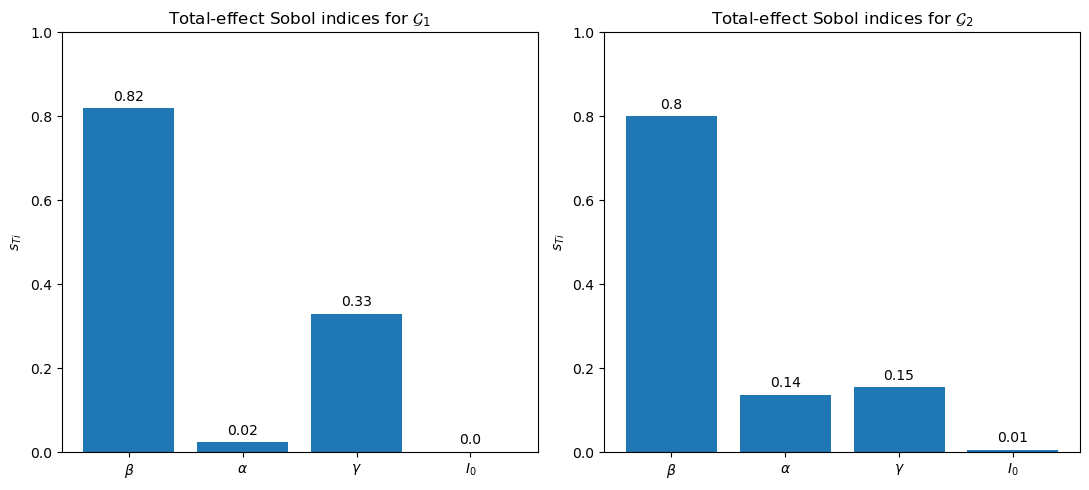

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
labels = [r'$\beta$', r'$\alpha$', r'$\gamma$', r'$I_0$']

# sTi1 for G1
bars1 = ax1.bar(labels, sTi_g1)
ax1.set_ylim(0, 1)
ax1.set_ylabel(r'$s_{Ti}$')
ax1.set_title(r'Total-effect Sobol indices for $\mathcal{G}_1$')

# Adding the exact sTi values on the bars for G1
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# sTi1 for G2
bars2 = ax2.bar(labels, sTi_g2)
ax2.set_ylim(0, 1)
ax2.set_ylabel(r'$s_{Ti}$')
ax2.set_title(r'Total-effect Sobol indices for $\mathcal{G}_2$')

# Adding the exact sTi1 values on the bars for G2
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()

### 8. Find a way to quantify the "amount of interaction between the variables"

In [33]:
# sum of all sTi will be one if there's no interaction

# interaction in G1
sum_sTi_g1 = np.sum(sTi_g1)
inter_Xi_g1 = sum_sTi_g1 - 1
print("Interaction between variables Xi in G1: %.2f" % inter_Xi_g1)

# interaction in G2
sum_sTi_g2 = np.sum(sTi_g1)
inter_Xi_g2 = sum_sTi_g2 - 1
print("Interaction between variables Xi in G2: %.2f" % inter_Xi_g2)

Interaction between variables Xi in G1: 0.18
Interaction between variables Xi in G2: 0.18
